# Topic Modeling

```yaml
Course:    DS 5001 
Module:    08 Homework
Topic:     Topic modeling homework
Author:    Andrew Avitabile
Date:      23 March 2024
```

# Set Up

## Config

In [1]:
import configparser
config = configparser.ConfigParser()
config.read('../../../env.ini')
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

## Imports

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px
from scipy.stats import entropy

In [3]:
data_prefix = 'novels'
colors = "YlGnBu"
OHCO = ['book_id', 'chap_num', 'para_num']
PARA = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

In [4]:
BAG = CHAP

# Get the Data

In [5]:
CORPUS = pd.read_csv(f'{data_home}/novels/{data_prefix}-CORPUS.csv')
LIB = pd.read_csv(f'{data_home}/novels/{data_prefix}-LIB.csv')

Create a short label for each author for display purposes.

## Data Prep

In [6]:
LIB['key'] =  + LIB.author_id + " - " + LIB.book_id + " - " + LIB.genre_id

In [7]:
OHCO = ['book_id', 'chap_id', 'para_num']
PARA = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

## Create DOCS

### Chapters as bag

In [8]:
BAG = CHAP

#Filtering to nouns
DOCS_CHAP = CORPUS[CORPUS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

### Paragraphs as bag

In [9]:
BAG = PARA

#Filtering to nouns
DOCS_PARA = CORPUS[CORPUS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

# Topic Modeling

In [10]:
def create_vector_space(documents, max_features=4000, ngram_range=(1, 2), stop_words='english'):
    # Create Vector Space with Scikit Learn's CountVectorizer
    count_engine = CountVectorizer(max_features=max_features, ngram_range=ngram_range, stop_words=stop_words)
    count_model = count_engine.fit_transform(documents.doc_str)
    TERMS = count_engine.get_feature_names_out()

    # Create VOCAB from terms
    VOCAB = pd.DataFrame(index=TERMS)
    VOCAB.index.name = 'term_str'

    # Create Document-Term Matrix (DTM)
    DTM = pd.DataFrame(count_model.toarray(), index=documents.index, columns=TERMS)

    return DTM, VOCAB, count_model, TERMS

In [11]:
vector_space_chap = create_vector_space(documents=DOCS_CHAP, max_features=4000, ngram_range=(1, 2), stop_words='english')

In [12]:
vector_space_para = create_vector_space(documents=DOCS_PARA, max_features=4000, ngram_range=(1, 2), stop_words='english')

In [13]:
DTM_CHAP = vector_space_chap[0]
VOCAB_CHAP = vector_space_chap[1]
COUNT_MODEL_CHAP = vector_space_chap[2]
TERMS_CHAP = vector_space_chap[3]

In [14]:
DTM_PARA = vector_space_para[0]
VOCAB_PARA = vector_space_para[1]
COUNT_MODEL_PARA = vector_space_para[2]
TERMS_PARA = vector_space_para[3]

In [15]:
VOCAB_CHAP['doc_count'] = DTM_CHAP.astype('bool').astype('int').sum()
DOCS_CHAP['term_count'] = DTM_CHAP.sum(1)

In [16]:
VOCAB_PARA['doc_count'] = DTM_PARA.astype('bool').astype('int').sum()
DOCS_PARA['term_count'] = DTM_PARA.sum(1)

# Generate Topic Models

We run Scikit Learn's [LatentDirichletAllocation algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation) and extract the THETA and PHI tables.

In [17]:
def run_LDA(documents, count_model, terms, n_topics = 20, max_iter = 5, learning_offset=50, random_state=0, n_terms_per_topic=7):
    #Run LDA
    lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=learning_offset, random_state=random_state)

    #Get topic names
    TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

    #Create model
    lda_model = lda_engine.fit_transform(count_model)

    #Get Theta
    THETA = pd.DataFrame(lda_model, index=documents.index)
    THETA.columns.name = 'topic_id'
    THETA.columns = TNAMES

    #Get PHI
    PHI = pd.DataFrame(lda_engine.components_, columns=terms, index=TNAMES)
    PHI.index.name = 'topic_id'
    PHI.columns.name = 'term_str'

    #Create topics
    TOPICS = PHI.stack().groupby('topic_id')\
        .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(n_terms_per_topic).reset_index().term_str))\
        .to_frame('top_terms')
    
    return TOPICS, THETA, PHI

In [18]:
LDA_PARA = run_LDA(documents=DOCS_PARA, count_model=COUNT_MODEL_PARA, terms = TERMS_PARA, n_topics = 20, max_iter = 5, learning_offset=50, random_state=0, n_terms_per_topic=7)

In [19]:
TOPICS_PARA = LDA_PARA[0]
THETA_PARA = LDA_PARA[1]
PHI_PARA = LDA_PARA[2]

In [21]:
LDA_CHAP = run_LDA(documents=DOCS_CHAP, count_model=COUNT_MODEL_CHAP, terms = TERMS_CHAP, n_topics = 20, max_iter = 5, learning_offset=50, random_state=0, n_terms_per_topic=7)

In [22]:
TOPICS_CHAP = LDA_CHAP[0]
THETA_CHAP = LDA_CHAP[1]
PHI_CHAP = LDA_CHAP[2]

# Questions

1. Use the PHI table from each model to compute the entropy H of the distribution over topics. Which bag generates a lower entropy distribution? Hint: To get H work with the L1 normalized vector of word weight sums by topic in the PHI table.

Using paragraphs as bags has lower entropy

In [23]:
def compute_entropy(phi_table):
    # Sum probabilities of words for each topic
    word_weight_sums_by_topic = phi_table.sum(axis=1)
    
    # L1 normalize the word weight sums by topic
    normalized_topic_distributions = phi_table.div(word_weight_sums_by_topic, axis=0)

    # Compute entropy for each topic distribution, using entropy function from scipy.stats
    entropies = {}
    for topic, topic_distribution in normalized_topic_distributions.iterrows():
        entropy_value = entropy(topic_distribution, base=2)
        entropies[topic] = entropy_value
        
    # Convert the dictionary to a DataFrame
    entropy_df = pd.DataFrame(list(entropies.items()), columns=['topic_id', 'Entropy'])
    entropy_df.set_index('topic_id', inplace=True)
    
    # Sort topics by entropy in descending order
    sorted_topics = sorted(entropy_df.items(), key=lambda x: x[1], reverse=True)

    return entropy_df

In [24]:
entropies_CHAP = compute_entropy(PHI_CHAP)
entropies_PARA = compute_entropy(PHI_PARA)

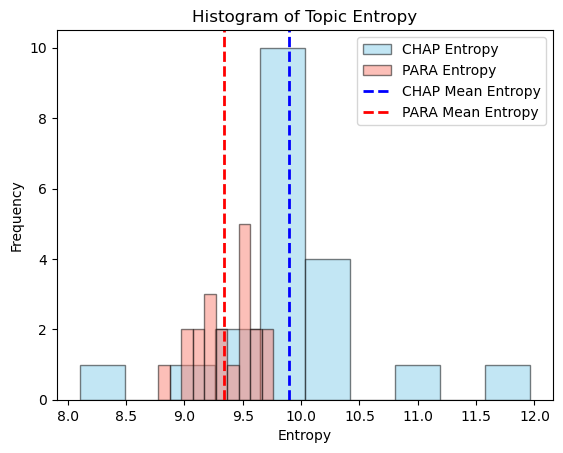

In [27]:
# Plot histogram for entropies_CHAP
plt.hist(entropies_CHAP['Entropy'], bins=10, color='skyblue', alpha=0.5, edgecolor='black', label='CHAP Entropy')

# Plot histogram for entropies_PARA
plt.hist(entropies_PARA['Entropy'], bins=10, color='salmon', alpha=0.5, edgecolor='black', label='PARA Entropy')

# Calculate mean entropy for each DataFrame
mean_entropy_CHAP = entropies_CHAP['Entropy'].mean()
mean_entropy_PARA = entropies_PARA['Entropy'].mean()

# Add mean entropy lines
plt.axvline(mean_entropy_CHAP, color='blue', linestyle='--', linewidth=2, label='CHAP Mean Entropy')
plt.axvline(mean_entropy_PARA, color='red', linestyle='--', linewidth=2, label='PARA Mean Entropy')

# Add labels and title
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.title('Histogram of Topic Entropy')
plt.legend()

# Show plot
plt.show()

2. Sort the topics in each model's PHI table by topic entropy in descending order. Are the first topics in the two models about the same? In other words, do they yield similar interpretations?

No, they seem to yield top topics with different interpretations.

In [28]:
# Print the first topics in both models
TOPICS_CHAP_W_ENT = pd.merge(TOPICS_CHAP, entropies_CHAP, on='topic_id', how='left')
TOPICS_PARA_W_ENT = pd.merge(TOPICS_CHAP, entropies_PARA, on='topic_id', how='left')

In [29]:
TOPICS_CHAP_W_ENT.sort_values(by='Entropy', ascending=False).head(5)

,top_terms,Entropy
topic_id,,
T08,regardless pauses vaults infamy hastily le ind...,11.965784
T11,daughter faith rumours stories answer women farm,10.968628
T02,man time way hand room day night,10.318257
T16,woods mind air scene heart voice chateau,10.189777
T00,son father man heart time hand chamber,10.079680


In [30]:
TOPICS_PARA_W_ENT.sort_values(by='Entropy', ascending=False).head(5)

,top_terms,Entropy
topic_id,,
T05,man eyes life time day men death,9.760595
T14,mountains way guides light sound gate man,9.687793
T08,regardless pauses vaults infamy hastily le ind...,9.652509
T10,time heart friend family brother moment room,9.637622
T12,moor man night face time eyes window,9.511115


3. What topic from each model is most strongly associated with each genre? Note that your answer have four parts.

Using chapters as the bag: 
- Topic T01 is most strongly associated with detective novels.
- Topic T10 is most strongly associated with gothic novels.
    
Using paragraphs as the bag:
- Topic T11 is most strongly associated with detective novels.
- Topic T10 is most strongly associated with gothic novels.

In [78]:
THETA_CHAP_CL = pd.merge(THETA_CHAP.reset_index(), LIB, on='book_id', how='left').set_index(['book_id', 'genre_id', 'author_id', 'key', 'chap_id'])
THETA_PARA_CL = pd.merge(THETA_PARA.reset_index(), LIB, on='book_id', how='left').set_index(['book_id', 'genre_id', 'author_id', 'key', 'chap_id', 'para_num'])

In [74]:
topic_by_genre_CHAP = THETA_CHAP_CL.groupby('genre_id').mean().idxmax(axis=1)
topic_by_genre_CHAP = pd.DataFrame({'topic_id': topic_by_genre_CHAP}).reset_index()
pd.merge(topic_by_genre_CHAP, TOPICS_CHAP, on='topic_id', how='inner')

,genre_id,topic_id,top_terms
0,d,T01,room yes man time door face way
1,g,T10,time heart friend family brother moment room


In [79]:
topic_by_genre_PARA = THETA_PARA_CL.groupby('genre_id').mean().idxmax(axis=1)
topic_by_genre_PARA = pd.DataFrame({'topic_id': topic_by_genre_PARA}).reset_index()
pd.merge(topic_by_genre_PARA, TOPICS_PARA, on='topic_id', how='inner')

,genre_id,topic_id,top_terms
0,d,T11,lady business right matter things years mind
1,g,T10,mind day night hour hope steps time


4. Using the THETA table from the Chapters model, get the mean topic weights for each book. Which book is most strongly associated with the gothic genre g, based on the weight of that genre's most representative topic (as discovered in the previous question)?

Assuming T10 is the topic most closely associated with gothic novels, Frankenstein is most strongly associated with the gothic genre.

In [95]:
THETA_PARA_CL.groupby('key').mean()[['T10']].sort_values(by='T10', ascending=False).head(1)

,T10
key,
shelley - frankenstein - g,0.179294


5. How would you characterize the subject matter of the two genres based on their topic models? Consider the words associated with the dominant topics from each model, but also the models overall.

Novels in the detective genre tend to have:
- Involve a corpse, body or murder (e.g., T03).
- Have women in them (e.g., T11) and other family members (e.g., T00).

Whereas novels in the gothic genre tend to have:
- Seem to involve family or friends (e.g., T10).
- Describe bodily or facial features (e.g., T04, T12).

In [124]:
topics_by_genre = THETA_PARA_CL.groupby('genre_id').mean().reset_index().melt(id_vars='genre_id', var_name='topic_id', value_name='mean_theta').groupby('genre_id').apply(lambda group: group.nlargest(5, 'mean_theta'))
pd.merge(topics_by_genre, TOPICS_CHAP, on='topic_id', how='inner').set_index('genre_id')

,topic_id,mean_theta,top_terms
genre_id,,,
d,T11,0.068147,daughter faith rumours stories answer women farm
d,T03,0.066646,corpse body murder evidence period thicket river
d,T00,0.062800,son father man heart time hand chamber
d,T18,0.060606,time way house place door night man
d,T13,0.056803,tm work works terms agreement tm works donations
g,T10,0.073501,time heart friend family brother moment room
g,T09,0.071771,night time hand face dear day way
g,T04,0.069584,eyes heart hand moment bosom oh voice
g,T12,0.063778,moor man night face time eyes window
